In [2]:
import numpy as np
import time
import matplotlib.pyplot as plt

In [ ]:
# ------------------------------------------------------------
# (1) MODEL PARAMETERS
# ------------------------------------------------------------
def mc_binomial_asian(S0, K, r, sigma, T, N, Ns, u, m, d, pu, pd):
    
    dt = T / N
    np.random.seed(42)     # reproducible

    choices = [0, 1, 2]
    probs = [pd, 1-pd-pu, pu]

    X = np.random.choice(choices, size=(Ns, N), p=probs)   # (Ns × N) matrix    


    # ------------------------------------------------------------
    # (3) CONSTRUCT PRICE PATHS
    # ------------------------------------------------------------

    log_u = np.log(u)
    log_m = np.log(m)
    log_d = np.log(d)


    # Build log-steps according to X
    log_steps = (
        (X == 2) * log_u +
        (X == 1) * log_m +
        (X == 0) * log_d
    )

    # cumulative sum → log prices
    log_paths = np.cumsum(log_steps, axis=1)

    # full price paths (without S0 column)
    S_paths = S0 * np.exp(log_paths)          # shape (Ns, N)

    # optional: include S0 at t=0
    S_with_S0 = np.concatenate(
        [np.full((Ns, 1), S0), S_paths],
        axis=1
    )


    average_price = S_paths.mean(axis=1)
    payoff = np.maximum(average_price - K, 0)
    price = np.exp(-r*T) * payoff.mean()
    stderr = payoff.std(ddof=1) / np.sqrt(Ns)     #uncertainty on the avearage, not of the indiviudal payoffs, so divide by sqrt(Ns)



    return price, stderr, S_with_S0




# TEST

In [70]:
""" Ns = 2
N = 5
pd = 0.2
pu = 0.3
u = 1.1
m = 1
d = 0.9
S0 = 100


choices = [0, 1, 2]
probs = [pd, 1-pd-pu, pu]

X = np.random.choice(choices, size=(Ns, N), p=probs)   # (Ns × N) matrix  
print(X)

log_u = np.log(u)
log_m = np.log(m)
log_d = np.log(d)


# Build log-steps according to X
log_steps = (
    (X == 2) * log_u +
    (X == 1) * log_m +
    (X == 0) * log_d
)

print("log_steps")
print(log_steps)

log_paths = np.cumsum(log_steps, axis=1)
print("log_paths")
print(log_paths)

S_paths = S0 * np.exp(log_paths)  
print("S_paths")
print(S_paths)

S_with_S0 = np.concatenate(
        [np.full((Ns, 1), S0), S_paths],
        axis=1
    )

print("S_with_S0")
print(S_with_S0)

average_price = S_paths.mean(axis=1)
print("average_price")
print(average_price)

 """

' Ns = 2\nN = 5\npd = 0.2\npu = 0.3\nu = 1.1\nm = 1\nd = 0.9\nS0 = 100\n\n\nchoices = [0, 1, 2]\nprobs = [pd, 1-pd-pu, pu]\n\nX = np.random.choice(choices, size=(Ns, N), p=probs)   # (Ns × N) matrix  \nprint(X)\n\nlog_u = np.log(u)\nlog_m = np.log(m)\nlog_d = np.log(d)\n\n\n# Build log-steps according to X\nlog_steps = (\n    (X == 2) * log_u +\n    (X == 1) * log_m +\n    (X == 0) * log_d\n)\n\nprint("log_steps")\nprint(log_steps)\n\nlog_paths = np.cumsum(log_steps, axis=1)\nprint("log_paths")\nprint(log_paths)\n\nS_paths = S0 * np.exp(log_paths)  \nprint("S_paths")\nprint(S_paths)\n\nS_with_S0 = np.concatenate(\n        [np.full((Ns, 1), S0), S_paths],\n        axis=1\n    )\n\nprint("S_with_S0")\nprint(S_with_S0)\n\naverage_price = S_paths.mean(axis=1)\nprint("average_price")\nprint(average_price)\n\n '

# MC

In [81]:
start = time.time()
price, stderr, S_paths = mc_binomial_asian(
    S0=100,
    K=100,
    r=0.05,
    sigma=0.2,
    T=1,
    N=20,
    Ns = 1000000,
    u=1.1,
    m=1.0,
    d=0.9,
    pu=0.2,
    pd=0.2)

end = time.time()
elapsed = end - start
print(f"Price: {price:.4f}, StdErr: {stderr:.4f}")
print(f"Elapsed time: {elapsed:.4f} seconds")

Price: 6.4360, StdErr: 0.0110
Elapsed time: 15.7423 seconds


In [82]:
def smooth_outliers_log(arr, log_threshold):
    """
    Replace elements in arr that differ too much from neighbors,
    but measuring differences in log-space (i.e., multiplicative scale).

    Parameters:
        arr (np.ndarray): 1D array of positive values.
        log_threshold (float): Maximum allowed log-difference.
                               e.g. log_threshold = log(2) → factor of 2.

    Returns:
        np.ndarray: Smoothed array.
    """
    arr = arr.copy()
    n = len(arr)

    # Work in log space
    log_arr = np.log(arr)

    for i in range(1, n - 1):
        prev_diff = abs(log_arr[i] - log_arr[i - 1])
        next_diff = abs(log_arr[i] - log_arr[i + 1])

        # If log-differences exceed threshold → multiplicative outlier
        if prev_diff > log_threshold and next_diff > log_threshold:
            # Replace using geometric mean (natural for log space)
            log_arr[i] = 0.5 * (log_arr[i - 1] + log_arr[i + 1])

    # Convert back
    return np.exp(log_arr)


In [ ]:
price_list = []
stderr_list = []
elapsed_list = []

for Ns in np.logspace(4, 5, 10, dtype=int):
    start = time.time()
    price, stderr, S_paths = mc_binomial_asian(
        S0=100,
        K=100,
        r=0.05,
        sigma=0.2,
        T=1,
        N=17,
        Ns=Ns,
        u=1.1,
        m=1.0,
        d=0.9,
        pu=0.2,
        pd=0.2)
    end = time.time()
    elapsed = end - start

    price_list.append(price)
    stderr_list.append(stderr)
    elapsed_list.append(elapsed)
    
    

    print(f"Ns={Ns:>7}: Price: {price:.4f}, StdErr: {stderr:.4f}, Elapsed time: {elapsed:.4f} seconds")

Ns=  10000: Price: 5.9640, StdErr: 0.1012, Elapsed time: 0.0586 seconds
Ns=  10060: Price: 5.9600, StdErr: 0.1008, Elapsed time: 0.0231 seconds
Ns=  10120: Price: 5.9563, StdErr: 0.1005, Elapsed time: 0.0243 seconds
Ns=  10180: Price: 5.9576, StdErr: 0.1002, Elapsed time: 0.0219 seconds
Ns=  10240: Price: 5.9498, StdErr: 0.0998, Elapsed time: 0.0211 seconds
Ns=  10300: Price: 5.9472, StdErr: 0.0995, Elapsed time: 0.0222 seconds
Ns=  10360: Price: 5.9406, StdErr: 0.0992, Elapsed time: 0.0220 seconds
Ns=  10420: Price: 5.9299, StdErr: 0.0988, Elapsed time: 0.0213 seconds
Ns=  10480: Price: 5.9329, StdErr: 0.0986, Elapsed time: 0.0261 seconds
Ns=  10540: Price: 5.9540, StdErr: 0.0985, Elapsed time: 0.0226 seconds
Ns=  10600: Price: 5.9526, StdErr: 0.0981, Elapsed time: 0.0225 seconds
Ns=  10660: Price: 5.9654, StdErr: 0.0980, Elapsed time: 0.0234 seconds
Ns=  10720: Price: 5.9667, StdErr: 0.0978, Elapsed time: 0.0235 seconds
Ns=  10780: Price: 5.9776, StdErr: 0.0976, Elapsed time: 0.0303 

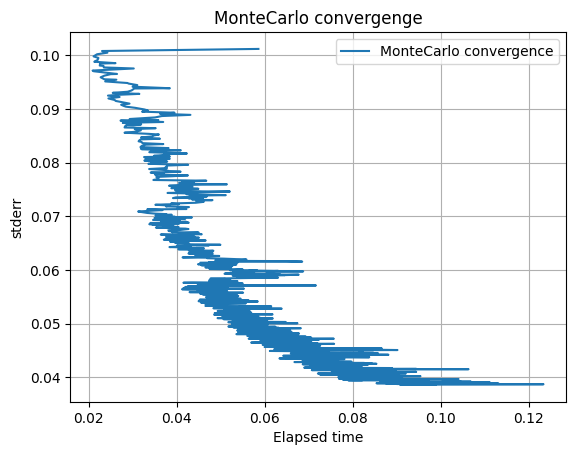

In [ ]:
# Create the plot
smoothed_elapsed = smooth_outliers_log(np.array(elapsed_list), log_threshold=0.01)
plt.plot(smoothed_elapsed, stderr_list, label='MonteCarlo convergence')
plt.xscale('log')
plt.xlabel('Elapsed time')
plt.ylabel('stderr')
plt.title('MonteCarlo convergenge')
plt.legend()
plt.grid(True)
plt.show()